# AUTOMATIC IMAGE DETECTION 



In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(384, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=[-30, 30]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = './four_classes' # Data directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']} # creates dic for train, val and test and transform
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4) #load data into batches
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} # stores samples in each set
class_names = image_datasets['train'].classes # retrieve class names 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device to cuda if available

# Example output
print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")
print(f"Device: {device}")

Class names: ['A', 'C', 'M', 'N']
Dataset sizes: {'train': 2638, 'val': 293, 'test': 733}
Device: cpu


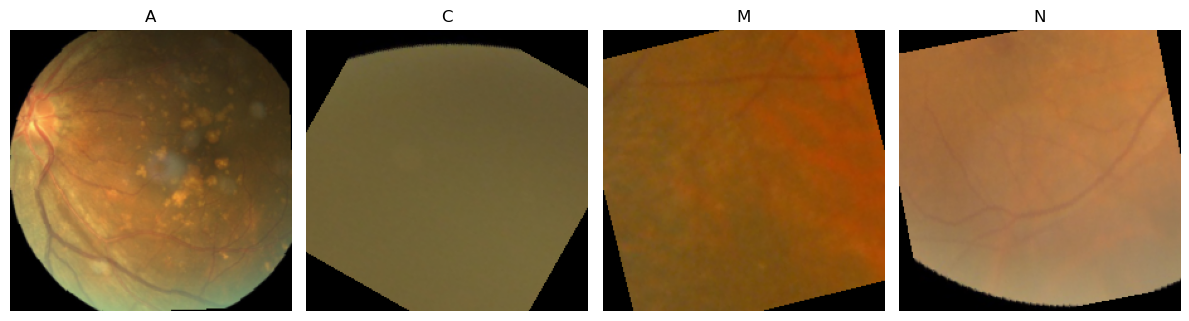

In [4]:
# Define a function to retrieve one image per class
def get_one_image_per_class(dataset):
    class_images = {}
    for img, label in dataset:
        class_name = class_names[label]
        if class_name not in class_images:
            class_images[class_name] = img
        if len(class_images) == len(class_names):
            break
    return class_images

# Define the imshow function for individual images
def imshow(inp):
    """Convert Tensor to numpy and reverse normalization for display."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# Retrieve one image per class
class_images = get_one_image_per_class(image_datasets['train'])

# Display images
plt.figure(figsize=(12, 4))
rows, cols = 1, len(class_images)
for i, (class_name, img_tensor) in enumerate(class_images.items(), 1):
    plt.subplot(rows, cols, i)
    img = imshow(img_tensor)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the scheduler after the optimizer
            if phase == 'train':
                scheduler.step()

            # For graph generation
            if phase == "train":
                train_loss.append(running_loss / dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss / dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:

from efficientnet_pytorch import EfficientNet
from torchsummary import summary


# Load EfficientNet-B4 with pretrained weights
model_ft = EfficientNet.from_pretrained('efficientnet-b4')

# Modify the classifier to match the number of classes 
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Print the model summary before training
summary(model_ft, input_size=(3, 224, 224))



Loaded pretrained weights for efficientnet-b4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13        

In [8]:
# Train the model 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6862 Acc: 0.7983
val Loss: 0.3384 Acc: 0.8874

Epoch 2/25
----------
train Loss: 0.3512 Acc: 0.8859
val Loss: 0.2264 Acc: 0.9283

Epoch 3/25
----------
train Loss: 0.2744 Acc: 0.9151
val Loss: 0.1793 Acc: 0.9386

Epoch 4/25
----------
train Loss: 0.2387 Acc: 0.9189
val Loss: 0.1834 Acc: 0.9317

Epoch 5/25
----------
train Loss: 0.2220 Acc: 0.9268
val Loss: 0.1926 Acc: 0.9420

Epoch 6/25
----------
train Loss: 0.1984 Acc: 0.9378
val Loss: 0.1917 Acc: 0.9317

Epoch 7/25
----------
train Loss: 0.1861 Acc: 0.9375
val Loss: 0.1967 Acc: 0.9420

Epoch 8/25
----------
train Loss: 0.1558 Acc: 0.9507
val Loss: 0.1857 Acc: 0.9454

Epoch 9/25
----------
train Loss: 0.1634 Acc: 0.9500
val Loss: 0.1856 Acc: 0.9420

Epoch 10/25
----------
train Loss: 0.1447 Acc: 0.9534
val Loss: 0.1879 Acc: 0.9386

Epoch 11/25
----------
train Loss: 0.1466 Acc: 0.9511
val Loss: 0.1938 Acc: 0.9420

Epoch 12/25
----------
train Loss: 0.1418 Acc: 0.9545
val Loss: 0.1860 Acc: 0.9454

E

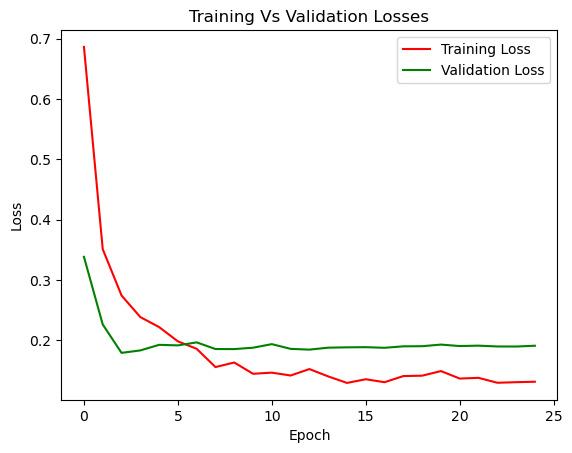

In [9]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

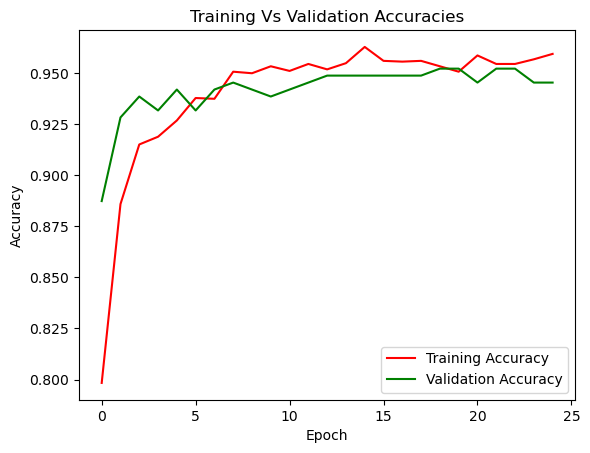

In [10]:
#Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
plt.plot(epoch_counter_val,val_acc,color = 'g', label="Validation Accuracy")
plt.legend()
plt.show()

In [11]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 93 %


In [12]:
#Class wise testing accuracy
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 71 %
Accuracy of     C : 83 %
Accuracy of     M : 91 %
Accuracy of     N : 96 %


In [13]:
def make_predictions(model_ft, data, device):
    pred_probs = []
    model_ft.to(device)
    model_ft.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.to(device)  # Remove torch.unsqueeze
            pred_logit = model_ft(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


In [14]:
import random

# Assuming dataloaders['test'] provides batches of data
test_samples = []
test_labels = []

# Flatten the list of batches into individual samples
all_samples = [(sample, label) for batch in dataloaders['test'] for sample, label in zip(batch[0], batch[1])]

# Sample 20 individual samples and labels
for sample, label in random.sample(all_samples, k=20):
    test_samples.append(sample)
    test_labels.append(label)

# Check the shape of the first sample to confirm
print(test_samples[0].shape)  # Should print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])


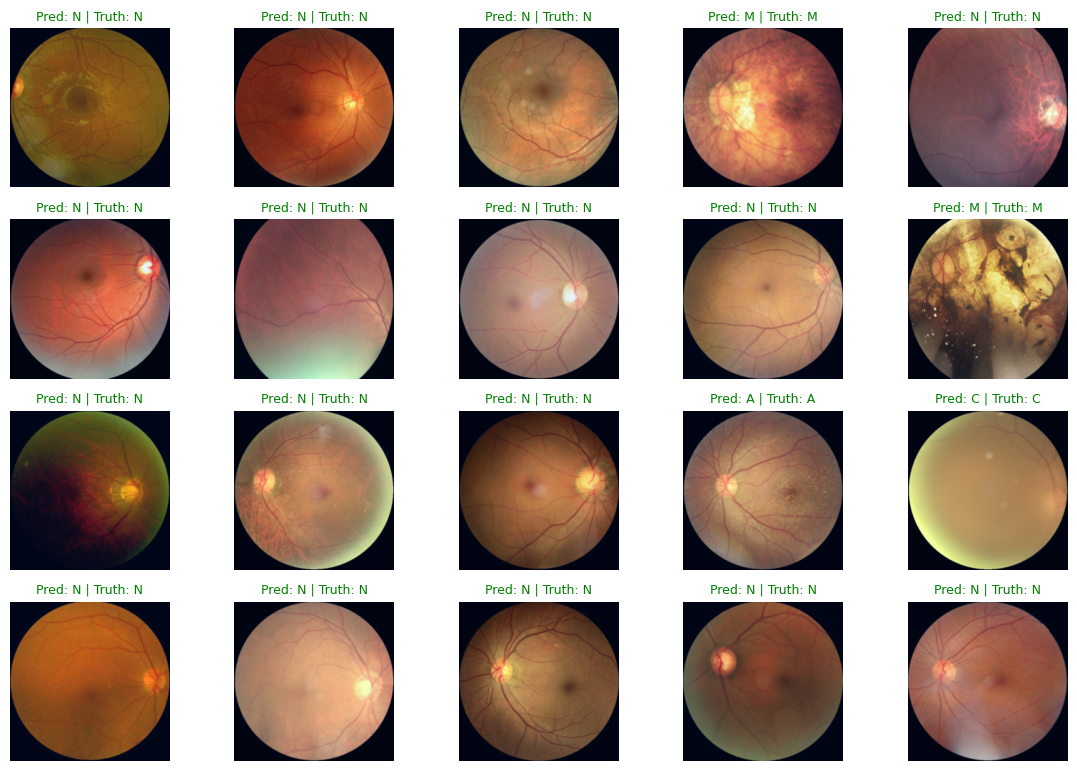

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure class_names matches the number of classes your model predicts
class_names = ['A', 'C','M', 'N']

# Get predictions for the test samples
model_ft.eval()  # Ensure model is in evaluation mode
pred_classes = []

with torch.no_grad():
    for i in range(len(test_samples)):
        sample = test_samples[i].unsqueeze(0)  # Add batch dimension
        outputs = model_ft(sample.to(device))
        _, predicted = torch.max(outputs, 1)
        pred_classes.append(predicted.item())

# Plot predictions
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5

for i in range(len(test_samples)):
    plt.subplot(nrows, ncols, i + 1)
    sample = test_samples[i]
    # Convert PyTorch tensor to NumPy array
    normalized_sample = sample.permute(1, 2, 0).cpu().numpy()  # Ensure tensor is on CPU
    normalized_sample = (normalized_sample - np.min(normalized_sample)) / (np.max(normalized_sample) - np.min(normalized_sample))  # Normalize pixel values to [0, 1]
    plt.imshow(normalized_sample)

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i].item()]  # Ensure label is scalar

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check equality between pred and truth and change color of title
    if pred_label == truth_label:
        plt.title(title_text, fontsize=9, c="g")
    else:
        plt.title(title_text, fontsize=9, c="r")

    plt.axis(False)
plt.show()


In [16]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
import torchnet.meter.confusionmeter as cm

# Initialize confusion matrix
confusion_matrix = cm.ConfusionMeter(4)
all_labels = []
all_preds = []
all_probs = []

# Process test data
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = nn.functional.softmax(outputs, dim=1)
        confusion_matrix.add(predicted, labels)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Binarize the labels for AUC calculation
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)
auc = roc_auc_score(all_labels_bin, all_probs, average=None, multi_class='ovr')
kappa = cohen_kappa_score(all_labels, all_preds)

# Calculate average metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')
precision_micro = precision_score(all_labels, all_preds, average='micro')
recall_micro = recall_score(all_labels, all_preds, average='micro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
auc_macro = np.mean(auc)  # Average AUC across all classes

# Calculate specificity
conf_matrix = confusion_matrix.conf
sensitivity = []
specificity = []

for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fn + fp)
    
    sensitivity.append(tp / (tp + fn))  # True Positive Rate
    specificity.append(tn / (tn + fp))  # True Negative Rate

specificity_macro = np.mean(specificity)  # Average specificity across all classes

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa Score: {kappa:.4f}')
print(f'Precision (Micro): {precision_micro:.4f}')
print(f'Recall (Micro): {recall_micro:.4f}')
print(f'F1-Score (Micro): {f1_micro:.4f}')
print(f'AUC (Macro): {auc_macro:.4f}')
print(f'Specificity (Macro): {specificity_macro:.4f}')
for i in range(len(precision)):
    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}, AUC: {auc[i]:.4f}, Sensitivity: {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}')


Confusion Matrix:
 [[ 38   0   1  14]
 [  0  49   0  10]
 [  0   0  42   4]
 [  4  13   1 557]]
Accuracy: 0.9359
Kappa Score: 0.8215
Precision (Micro): 0.9359
Recall (Micro): 0.9359
F1-Score (Micro): 0.9359
AUC (Macro): 0.9574
Specificity (Macro): 0.9487
Class 0 - Precision: 0.9048, Recall: 0.7170, F1-Score: 0.8000, AUC: 0.9315, Sensitivity: 0.7170, Specificity: 0.9941
Class 1 - Precision: 0.7903, Recall: 0.8305, F1-Score: 0.8099, AUC: 0.9608, Sensitivity: 0.8305, Specificity: 0.9807
Class 2 - Precision: 0.9545, Recall: 0.9130, F1-Score: 0.9333, AUC: 0.9979, Sensitivity: 0.9130, Specificity: 0.9971
Class 3 - Precision: 0.9521, Recall: 0.9687, F1-Score: 0.9603, AUC: 0.9392, Sensitivity: 0.9687, Specificity: 0.8228


<Axes: >

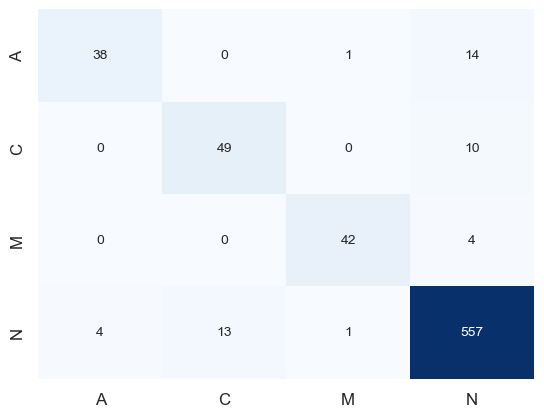

In [17]:
#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

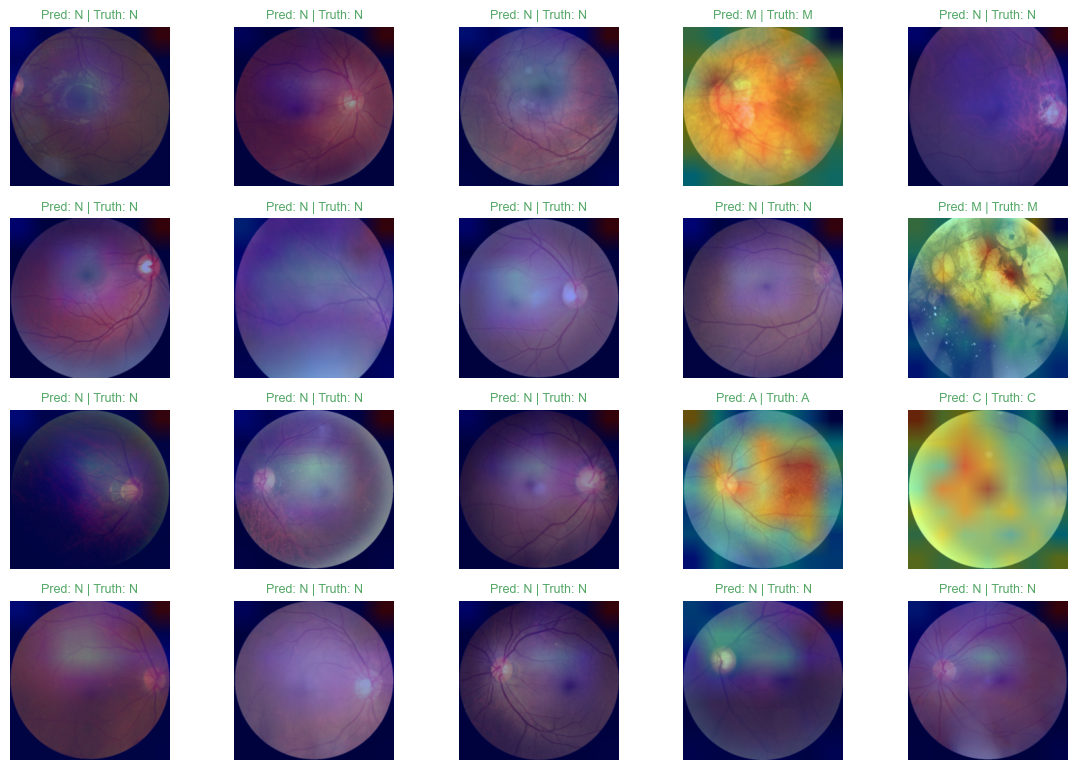

In [18]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM: #1st Gradcam for 
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)  # Changed to register_full_backward_hook

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.zero_grad()
        input_tensor.requires_grad = True  # Ensure input tensor requires gradients
        output = self.model(input_tensor)
        target = output[0][class_idx]
        target.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = torch.mean(gradients, dim=[1, 2], keepdim=True)
        heatmap = torch.sum(weights * activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

# Ensure class_names matches the number of classes your model predicts
class_names = ['A', 'C', 'M', 'N']

# Choose a layer from EfficientNet's feature extractor
# This example uses the layer just before the final pooling layer
target_layer = model_ft._blocks[-1]._project_conv  # Adjust if needed; usually last conv layer

grad_cam = GradCAM(model_ft, target_layer)

# Get predictions for the test samples
model_ft.eval()  # Ensure model is in evaluation mode
pred_classes = []

with torch.no_grad():
    for i in range(len(test_samples)):
        sample = test_samples[i].unsqueeze(0)  # Add batch dimension
        outputs = model_ft(sample.to(device))
        _, predicted = torch.max(outputs, 1)
        pred_classes.append(predicted.item())

# Plot predictions with Grad-CAM heatmaps
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5

for i in range(len(test_samples)):
    plt.subplot(nrows, ncols, i + 1)
    sample = test_samples[i]
    # Convert PyTorch tensor to NumPy array
    normalized_sample = sample.permute(1, 2, 0).cpu().numpy()  # Ensure tensor is on CPU
    normalized_sample = (normalized_sample - np.min(normalized_sample)) / (np.max(normalized_sample) - np.min(normalized_sample))  # Normalize pixel values to [0, 1]
    normalized_sample = (normalized_sample * 255).astype(np.uint8)  # Convert to uint8

    # Generate Grad-CAM heatmap
    heatmap = grad_cam.generate_heatmap(sample.unsqueeze(0).to(device), pred_classes[i])
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (normalized_sample.shape[1], normalized_sample.shape[0]))
    overlay = cv2.addWeighted(normalized_sample, 0.6, heatmap, 0.4, 0)

    plt.imshow(overlay)

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i].item()]  # Ensure label is scalar

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check equality between pred and truth and change color of title
    if pred_label == truth_label:
        plt.title(title_text, fontsize=9, c="g")
    else:
        plt.title(title_text, fontsize=9, c="r")

    plt.axis(False)
plt.show()
